# Data Understanding
In this notebook I am going to to take a look at the Boston AirBnB data: https://www.kaggle.com/airbnb/boston. My goal is to explore some basic trends in the types of listings.

In [703]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from collections import defaultdict

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [592]:
listings_df = pd.read_csv('Boston/Listings.csv')

# Drop variables will all there values missing
listings_df = listings_df.dropna(axis=1, how='all')

# Drop variables that are the same for every listing
for column in listings_df:
    if listings_df[column].value_counts().shape[0] == 1:
        listings_df = listings_df.drop(columns=column)
        
# Drop not relevant predicitions
listings_df = listings_df.drop(columns=['id', 'host_id', 'host_name'])
set(listings_df.columns)

{'access',
 'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'description',
 'extra_people',
 'first_review',
 'guests_included',
 'host_about',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_neighbourhood',
 'host_picture_url',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'house_rules',
 'instant_bookable',
 'interaction',
 'is_location_exact',
 'last_review',
 'latitude',
 'listing_url',
 'longitude',
 'market',
 'maximum_nights',
 'medium_url',
 'minimum_nights',
 'monthly_price',
 'name',
 'neighborhood_overview',
 'neighbourhood',
 'neighbourhood_cleansed',
 'note

There are many variables (columns in the pandas DataFrame) that have data from every single listing (rows in the pandas DataFrame).

In [482]:
no_nulls = listings_df.columns[listings_df.isnull().mean() == 0]
print('There are %d columns with no missing values.' % (no_nulls.shape[0]))
set(no_nulls)

There are 40 columns with no missing values.


{'accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bed_type',
 'calculated_host_listings_count',
 'calendar_updated',
 'cancellation_policy',
 'description',
 'extra_people',
 'guests_included',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_picture_url',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'instant_bookable',
 'is_location_exact',
 'latitude',
 'listing_url',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'name',
 'neighbourhood_cleansed',
 'number_of_reviews',
 'picture_url',
 'price',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'room_type',
 'smart_location',
 'street'}

In [593]:
most_missing_cols = listings_df.columns[listings_df.isnull().mean() > 0.5]

print('There are %d columns with more than half of their values missing.' % (most_missing_cols.shape[0]))
set(most_missing_cols)

There are 5 columns with more than half of their values missing.


{'monthly_price', 'notes', 'security_deposit', 'square_feet', 'weekly_price'}

In [594]:
some_missing_cols = listings_df.columns[listings_df.isnull().mean() < 0.25]

print('There are %d columns with more most of their values.' % (some_missing_cols.shape[0]))

There are 67 columns with more most of their values.


The price column needs to be converted from a string to a numeric value.

In [595]:
print(listings_df['price'][0])
print(listings_df['cleaning_fee'][0])

$250.00
$35.00


In [596]:
# Convert the price data from strings to integers.
listings_df['price'] = listings_df['price'].apply(lambda p: float(p[1:].replace(",", "")))
listings_df['cleaning_fee'] = listings_df['cleaning_fee'].dropna().apply(lambda p: float(p[1:]))

print('The average cost of a rental is $%d.' % (listings_df['price'].mean()))
print('The average cleaning fee is $%d.' % (listings_df['cleaning_fee'].mean()))

The average cost of a rental is $173.
The average cleaning fee is $68.


In [597]:
listings_df['security_deposit'] = listings_df['security_deposit'].dropna().apply(lambda p: float(p[1:].replace(",", "")))
print('The average security deposit fee is $%d.' % (listings_df['cleaning_fee'].mean()))

The average security deposit fee is $68.


## Data Exploration
How much does being able to rent the entire place increase the price?

In [598]:
def plot_mean_price(df, col):
    listings_df.groupby([col]).mean()['price'].plot(kind='bar');
    plt.title('How much does ' + col + ' matter?');
    plt.ylabel("Average Cost ($)");

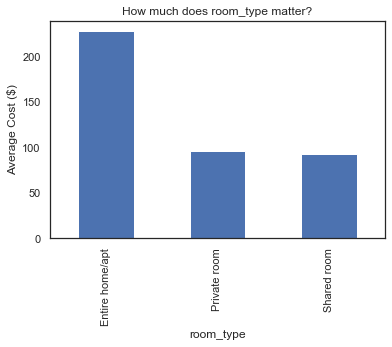

In [599]:
plot_mean_price(listings_df, 'room_type')

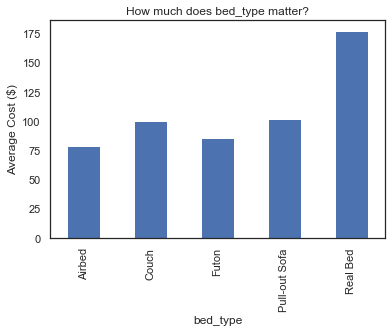

In [426]:
plot_mean_price(listings_df, 'bed_type')

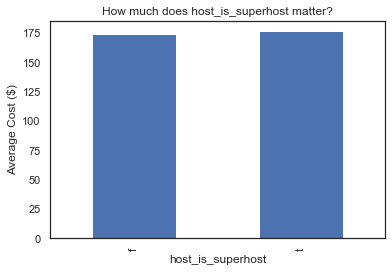

In [427]:
plot_mean_price(listings_df, 'host_is_superhost')

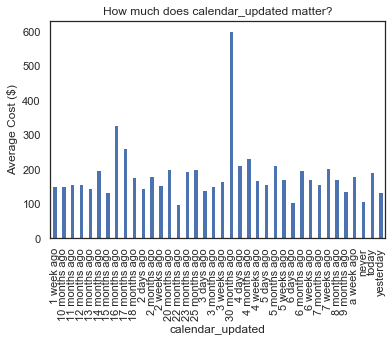

In [428]:
plot_mean_price(listings_df, 'calendar_updated')

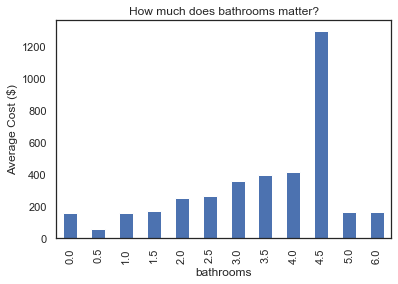

In [429]:
plot_mean_price(listings_df, 'bathrooms')

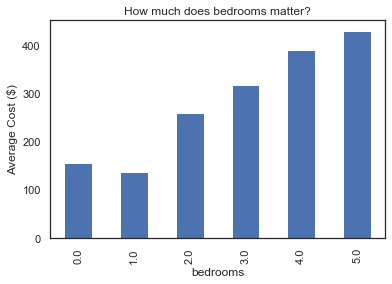

In [430]:
plot_mean_price(listings_df, 'bedrooms')

## Number of people listing can accommodate.
How much does the number of people who can share the room effect price? Very few listings allow more than 6 people.

Text(0, 0.5, '% of listings')

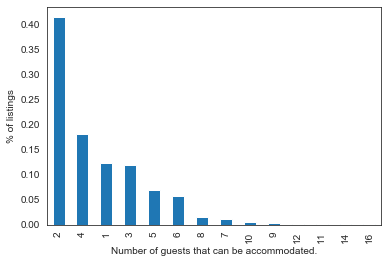

In [105]:
listings_vals = listings_df['accommodates'].value_counts()

(listings_vals/listings_df.shape[0]).plot(kind="bar")
plt.xlabel("Number of guests that can be accommodated.")
plt.ylabel("% of listings")

Drop the outliers with more than 10 people to accommodate.

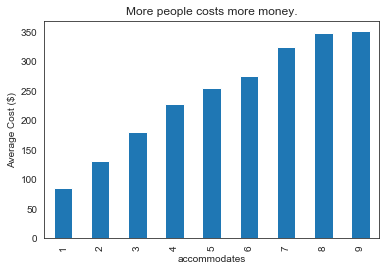

In [36]:
listings_df[listings_df['accommodates'] < 10].groupby(['accommodates']).mean()['price'].sort_values().plot(kind='bar');
plt.title("More people costs more money.");
plt.ylabel("Average Cost ($)");

However the price increase is not linear, as the cost per person is cheaper in a larger listing.

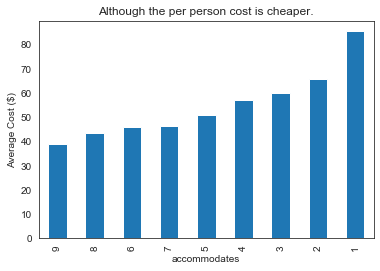

In [40]:
(listings_df[listings_df['accommodates'] < 10].groupby(['accommodates']).mean()['price']/listings_df[listings_df['accommodates'] < 10].groupby(['accommodates']).mean().index).sort_values().plot(kind='bar');
plt.title("Although the per person cost is cheaper.");
plt.ylabel("Average Cost ($)");

## Neighbourhods
Some neighbourhoods have more listings. Some neighbourhoods cost more money.

In [41]:
print('%f values missing from this column.' % (listings_df['neighbourhood'].isnull().mean()))

0.151464 values missing from this column.


Text(0, 0.5, 'Number of listings.')

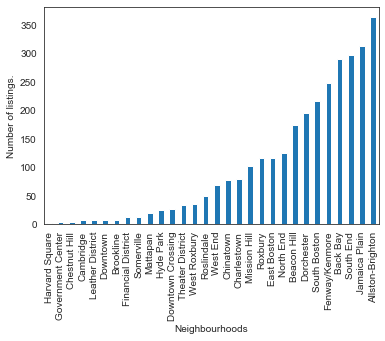

In [42]:
listings_df['neighbourhood'].dropna().value_counts().sort_values().plot(kind='bar')
plt.xlabel("Neighbourhoods")
plt.ylabel("Number of listings.")

Text(0, 0.5, 'Average price.')

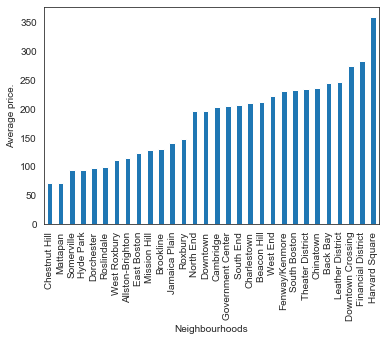

In [43]:
listings_df.groupby(['neighbourhood']).mean()['price'].sort_values().plot(kind='bar')
plt.xlabel("Neighbourhoods")
plt.ylabel("Average price.")

# Wrangling the Ammenities column

In [613]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
                
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [614]:
possible_vals = ["TV", "Cable TV","Air Conditioning","Kitchen",
                 "Heating","Washer","Dryer", "Gym", "Elevator in Building", "Family/Kid Friendly",
                 "Pool", "Internet"]

def clean_and_plot(df, title='', plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df['amenities'].value_counts().reset_index()
    study.rename(columns={'index': 'amenity', 'amenities': 'count'}, inplace=True)
    study_df = total_count(study, 'amenity', 'count', possible_vals)

    study_df.set_index('amenity', inplace=True)
    if plot:
        study_df.plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df
    return props_study_df


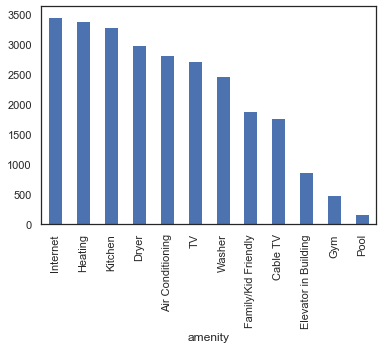

,count
amenity,
Internet,3459
Heating,3384
Kitchen,3284
Dryer,2993
Air Conditioning,2821
TV,2725
Washer,2475
Family/Kid Friendly,1888
Cable TV,1770


In [615]:
clean_and_plot(listings_df)

In [616]:
X.head()

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,security_deposit,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
0,1,1,42.282619,-71.133068,4,1.5,2.0,3.0,858.464286,324.698212,...,0,91.916667,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,1,1.970908
1,1,1,42.286241,-71.134374,2,1.0,1.0,1.0,858.464286,95.000000,...,36,94.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1,1.300000
2,1,1,42.292438,-71.135765,2,1.0,1.0,1.0,858.464286,324.698212,...,41,98.000000,10.000000,9.000000,10.000000,10.000000,9.000000,10.000000,1,0.470000
3,1,1,42.281106,-71.121021,4,1.0,1.0,2.0,858.464286,100.000000,...,1,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1,1.000000
4,1,1,42.284512,-71.136258,2,1.5,1.0,2.0,858.464286,324.698212,...,29,99.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,1,2.250000


## First pass linear regression

In [706]:
X = listings_df.select_dtypes(include=['float', 'int']).dropna(axis=1).drop(columns=['price'])
y = listings_df.dropna(axis=1)['price']

X.shape

(3585, 14)

In [727]:
X = X[y<y.median()*3]
y = y[y<y.median()*3]

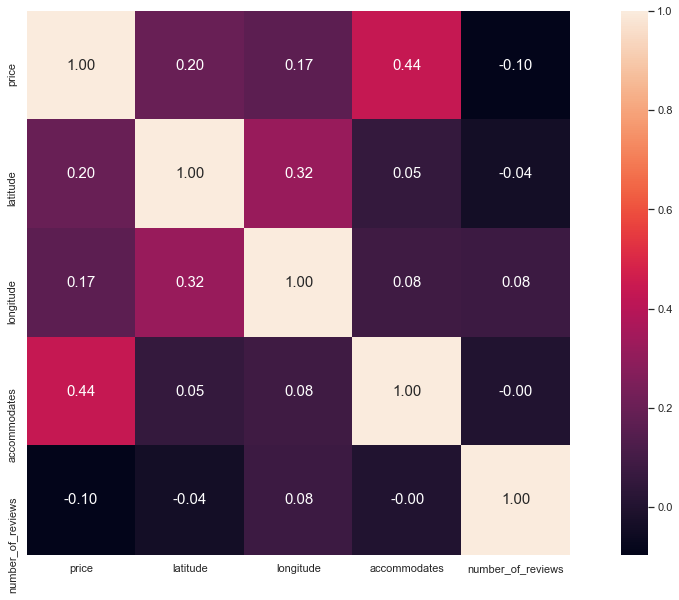

In [728]:
plt.figure(figsize=[18,10])
cols = ['price','latitude', 'longitude', 'accommodates', 'number_of_reviews']
cm = np.corrcoef(listings_df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15},
                    yticklabels=cols, xticklabels=cols)
plt.show()

In [729]:
# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

In [730]:
linear_regression = LinearRegression(normalize=True).fit(X_train, y_train)

In [731]:
print(mean_squared_error(linear_regression.predict(X_train), y_train)**0.5)
print(mean_squared_error(linear_regression.predict(X_test), y_test)**0.5)

64.16168647346333
63.33066153311029


In [732]:
linear_regression.score(X_test, y_test)

0.37869151403848567

## KNeighbors Regression

In [746]:
X = listings_df[['accommodates', 'latitude', 'longitude']]
y = listings_df['price']


In [747]:
X = X[y<y.median()*3]
y = y[y<y.median()*3]

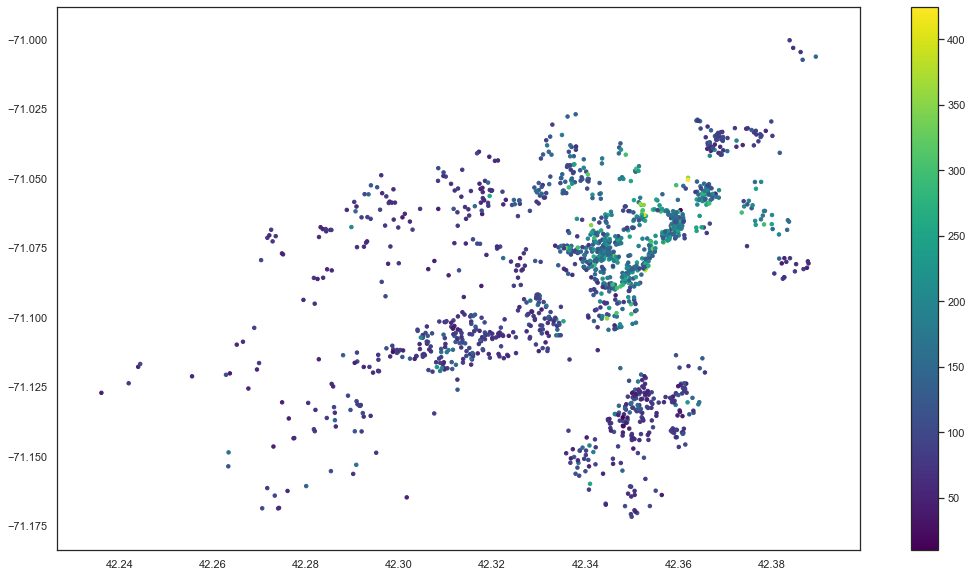

In [748]:
plt.figure(figsize=[18,10])
plt.scatter(X[X['accommodates']==2]['latitude'], X[X['accommodates']==2]['longitude'], c=y[X['accommodates']==2], cmap='viridis',s=12)
cbar = plt.colorbar()

In [749]:
# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

In [750]:
neigh = KNeighborsRegressor(n_neighbors=20).fit(X_train, y_train)

In [751]:
print(mean_squared_error(neigh.predict(X_train), y_train)**0.5)
print(mean_squared_error(neigh.predict(X_test), y_test)**0.5)

57.63699367508055
57.4214322402205


## Decision Tree

In [798]:
X = listings_df.select_dtypes(include=['float', 'int']).dropna(axis=1).drop(columns=['price'])
y = listings_df.dropna(axis=1)['price']

In [799]:
X = X[y<y.median()*3]
y = y[y<y.median()*3]

In [800]:
d_tree = DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)

In [801]:
print(mean_squared_error(d_tree.predict(X_train), y_train)**0.5)
print(mean_squared_error(d_tree.predict(X_test), y_test)**0.5)

59.46326729972797
60.26126926322838


## Random Forest

In [809]:
regr = RandomForestRegressor().fit(X_train, y_train)

In [810]:
print(mean_squared_error(d_tree.predict(X_train), y_train)**0.5)
print(mean_squared_error(d_tree.predict(X_test), y_test)**0.5)

59.46326729972797
60.26126926322838


In [804]:
regr.feature_importances_

array([0.62549915, 0.23050079, 0.14400006])

## Utilize variables with some NaN values

In [523]:
X = X[y<y.median()*2.5]
y = y[y<y.median()*2.5]

In [524]:
# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

In [525]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [526]:
linear_regression.score(X_test, y_test)

0.5009575356838485

In [527]:
(linear_regression.predict(X_test)-y_test).abs().mean()

43.8660315898513

In [528]:
mean_squared_error(linear_regression.predict(X_test), y_test)**0.5

56.758267812576506

In [588]:
clf = MLPRegressor(activation='relu',max_iter=200).fit(X_train, y_train)

In [589]:
clf.score(X_test, y_test)

0.2882051052232001

In [590]:
mean_squared_error(clf.predict(X_test), y_test)**0.5

67.78565802301657

## Utilize dummy variables

In [121]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [42]:
def drop_const_variables(df):
    for column in df:
    listings_df['state'].value_counts().shape[0]==1

True

IndexError: index 0 is out of bounds for axis 0 with size 0

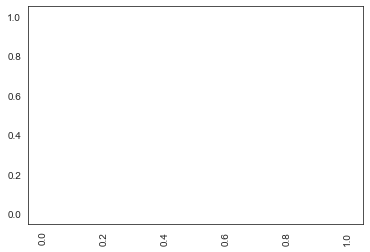

In [64]:
listings_df.groupby(['license']).mean()['price'].sort_values().plot(kind='bar');

Type license() to see the full license text